In [0]:
import tensorflow.compat.v1 as tf2
import numpy as np
import random 


class DataReader:
  def __init__(self, data_path, batch_size, vocab_size):
    self._batch_size= batch_size
    with open(data_path) as f:
      d_lines= f.read().splitlines()
    
    self._data=[]
    self._labels=[]
    for data_id, line in enumerate(d_lines):
      tfidf_vec= [0.0 for i in range(vocab_size)]
      feature= line.split('<fff>')
      label, doc_id= int(feature[0]), int(feature[1])
      tokens= feature[2].split()
      for token in tokens:
        ind, value= int(token.split(":")[0]), \
                    float(token.split(":")[1])
        tfidf_vec[ind]= value
      
      self._data.append(tfidf_vec)
      self._labels.append(label)

    self._data= np.array(self._data)
    self._labels= np.array(self._labels)

    self._num_epoch=0
    self._batch_id=0

  def next_batch(self):
    #lấy data từ trong batch tiếp theo và xáo chộn lên
    start= self._batch_id * self._batch_size
    end= start + self._batch_size
    self._batch_id +=1

    if end + self._batch_size > len(self._data):
      # khi đến batch cuối, một epoch có kích thước bằng data, nên 
      # khi chọn data set cho từng patch cần xáo chộn ngẫu nhiên rồi chọn cho đủ patch
      # dù cho trong 1 epoch có thể không chứa toàn bộ dữ liệu nhưng model có thể học dần 
      #dần thông qua các epoch
      end= len(self._data)
      self._num_epoch+=1 # chuyển sang epoch mới
      self._batch_id=0
      
      # xáo trộn data
      indices= list(range(len(self._data)))
      random.seed(2020)
      random.shuffle(indices)
      self._data, self._labels= self._data[indices], self._labels[indices]

    return self._data[start:end], self._labels[start:end]


In [0]:
# import tensorflow as tf
tf2.disable_eager_execution()

NUM_CLASSES= 20 #8
#Triển khai MLP
class MLP:
  def __init__(self, vocab_size, hidden_size):
    self._vocab_size= vocab_size
    self._hidden_size= hidden_size

  def build_graph(self):
    self._x= tf2.placeholder(tf2.float32, shape=[None, self._vocab_size])
    self._real_y= tf2.placeholder(tf2.int32, shape=[None,])

    # xây dựng biến chứa trọng số và bias cho các lớp
    with tf2.variable_scope("other_charge", reuse=tf2.AUTO_REUSE) as scope:
      weight_1= tf2.get_variable(
          name='weight_input_hidden',
          shape=(self._vocab_size,self._hidden_size),
          initializer= tf2.random_normal_initializer(seed=2020),
          # reuse= True
      )
      biases_1= tf2.get_variable(
          name='biases_input_hidden',
          shape=(self._hidden_size),
          initializer= tf2.random_normal_initializer(seed=2020),
          # reuse= True
      )

      weight_2= tf2.get_variable(
          name='weight_output_hidden',
          shape=(self._hidden_size, NUM_CLASSES),
          initializer= tf2.random_normal_initializer(seed=2020),
          # reuse= True
      )
      biases_2= tf2.get_variable(
          name='biases_output_hidden',
          shape=(NUM_CLASSES),
          initializer= tf2.random_normal_initializer(seed=2020),
          # reuse= True
      )

      # xây dựng mô hình computation graph
      hidden= tf.matmul(self._x, weight_1) + biases_1
      hidden= tf.sigmoid(hidden)
      logits= tf.matmul(hidden, weight_2)+ biases_2

      labels_one_hot= tf.one_hot(indices=self._real_y, depth= NUM_CLASSES,
                                dtype= tf.float32)
      loss= tf.nn.softmax_cross_entropy_with_logits(labels= labels_one_hot,
                                                    logits= logits)
      loss= tf.reduce_mean(loss)

      probs= tf.nn.softmax(logits)
      predicted_labels= tf.argmax(probs, axis=1)
      predicted_labels= tf.squeeze(predicted_labels)

    return predicted_labels, loss

  def trainer(self, loss, learning_rate):
    with tf2.variable_scope("other_charge", reuse=tf2.AUTO_REUSE) as scope:
      train_op= tf2.train.AdamOptimizer(learning_rate= learning_rate).minimize(loss)
    return train_op

#--------------------------------------------------------------------------------



step: 1, loss: 12.611571311950684
step: 2, loss: 9.164813041687012
step: 3, loss: 5.419309139251709
step: 4, loss: 1.963434100151062
step: 5, loss: 0.5800004601478577
step: 6, loss: 0.061471737921237946
step: 7, loss: 0.012930989265441895
step: 8, loss: 0.002346897730603814
step: 9, loss: 0.0002396911004325375
step: 10, loss: 5.840027332305908
step: 11, loss: 14.664942741394043
step: 12, loss: 14.024436950683594
step: 13, loss: 12.672224044799805
step: 14, loss: 10.911805152893066
step: 15, loss: 9.10333251953125
step: 16, loss: 7.419517993927002
step: 17, loss: 5.028095245361328
step: 18, loss: 2.8794009685516357
step: 19, loss: 1.201609492301941
step: 20, loss: 0.27794480323791504
step: 21, loss: 0.04956164211034775
step: 22, loss: 14.701445579528809
step: 23, loss: 20.409074783325195
step: 24, loss: 19.736095428466797
step: 25, loss: 19.06585693359375
step: 26, loss: 17.9831485748291
step: 27, loss: 16.06134796142578
step: 28, loss: 14.140690803527832
step: 29, loss: 12.162773132324

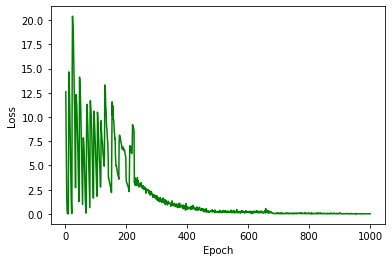

In [13]:
# with open('/content/drive/My Drive/Python code/DS_Lab/words-idfs.txt') as f:
with open('/content/drive/My Drive/Python code/DS_Lab2/Data/words_idfs.txt') as f:
  vocab_size= len(f.read().splitlines())

def load_dataset():
  # hàm gọi đối tượng đọc dữ liệu
  train_data_reader= DataReader(
      # data_path='/content/drive/My Drive/Python code/DS_Lab/train_tf_idf.txt',
      data_path='/content/drive/My Drive/Python code/DS_Lab2/Data/train_tf_idf.txt',
      batch_size= 50,
      vocab_size= vocab_size
  )
  test_data_reader= DataReader(
      # data_path='/content/drive/My Drive/Python code/DS_Lab/test_tf_idf.txt',
      data_path='/content/drive/My Drive/Python code/DS_Lab2/Data/test_tf_idf.txt',
      batch_size= 50,
      vocab_size= vocab_size
  )
  return train_data_reader, test_data_reader

def save_parameter(name, value, epoch):
  # hàm hỗ trợ lưu lại giá trị các tham số trong quá trình train
  filename= name.replace(":","-colon-")+ '-epoch-{}.txt'.format(epoch)
  if len(value.shape)==1: # là 1 list
    string_form= ','.join([str(number) for number in value])
  else:# la mot ma tran --> viet thanh nhieu hang
    string_form= '\n'.join([','.join([str(number) for number in value[row]]) for row in range(value.shape[0])])
  with open('/content/drive/My Drive/Python code/DS_Lab/Session 3 DS Lab/'+ filename,'w') as  f:
  # with open('/content/drive/My Drive/'+ filename,'w') as  f:
    f.write(string_form)

# thực thi mô hình coputation graph
mlp= MLP(
    vocab_size= vocab_size,
    hidden_size=50
)
predicted_labels, loss= mlp.build_graph()
train_op= mlp.trainer(loss= loss, learning_rate= 0.03)

train_data_reader, test_data_reader= load_dataset()
# mở một phiên chạy đồ thị
with tf2.Session() as sess:
  # train_data_reader, test_data_reader= load_dataset()
  step=0
  MAX_STEP= 1000
  
  steps=[]
  losses=[]
  sess.run(tf2.global_variables_initializer())
  while step < MAX_STEP:
    train_data, label_data= train_data_reader.next_batch()
    predicted_label_eval, loss_eval, _ = sess.run(
        [predicted_labels,loss, train_op],
        feed_dict={
            mlp._x: train_data,
            mlp._real_y: label_data
        }
    )
    step+=1
    steps.append(step)
    losses.append(loss_eval)
    print("step: {}, loss: {}".format(step, loss_eval))

    if loss_eval < 1e-5:
      break
    # trainable_variable= tf2.trainable_variables()
    # for variable in trainable_variable:
    #   save_parameter(
    #       name= variable.name,
    #       value= variable.eval(),
    #       epoch=train_data_reader._num_epoch
    #   )
  # lưu các tham số của mô hình trong quá trình training
  trainable_variable= tf2.trainable_variables()
  for variable in trainable_variable:
    save_parameter(
        name= variable.name,
        value= variable.eval(),
        epoch=train_data_reader._num_epoch
    )
  
  import matplotlib.pyplot as plt
  plt.plot(steps, losses, 'g')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

In [14]:
#khôi phục các tham số đã lưu
def restore_parameters(name, epoch):
  filename= name.replace(':','-colon-')+ '-epoch-{}.txt'.format(epoch)
  with open('/content/drive/My Drive/Python code/DS_Lab/Session 3 DS Lab/'+ filename) as f:
  # with open('/content/drive/My Drive/'+ filename) as f:
    line= f.read().splitlines()
    if len(line)==1: # là 1 list
      value= [float(number) for number in line[0].split(',')]
    else:
      value= [[float(number) for number in line[row].split(',')]\
              for row in range(len(line))]
  return value
  
# đánh giá model trên test
test_data_reader= DataReader(
    # data_path= '/content/drive/My Drive/Python code/DS_Lab/test_tf_idf.txt',
    data_path='/content/drive/My Drive/Python code/DS_Lab2/Data/test_tf_idf.txt',
    batch_size=50,
    vocab_size= vocab_size
)
mlp = MLP(
        vocab_size=vocab_size,
        hidden_size=50
        )
predicted_labels, loss = mlp.build_graph()
with tf2.Session() as sess:
  epoch=4

  trainable_variables= tf2.trainable_variables()
  for variable in trainable_variables:
    saved_value= restore_parameters(variable.name, epoch)
    assign_op= variable.assign(saved_value)
    sess.run(assign_op)
  
  num_true_pred=0
  while True:
    test_data, test_labels= test_data_reader.next_batch()
    test_plabel_eval= sess.run(
        predicted_labels,
        feed_dict={
            mlp._x: test_data,
            mlp._real_y: test_labels
        }
    )
    matches= np.equal(test_plabel_eval, test_labels)
    num_true_pred+= np.sum(matches.astype(float))

    if test_data_reader._batch_id==0:
      break
  print("Epoch: ", epoch)
  print("Accuracy on test data: ",num_true_pred/len(test_data_reader._data))


Epoch:  4
Accuracy on test data:  0.8035050451407328
